# Model prediction visualisation

In this notebook, we demonstrate how to load a trained model from MLFlow, trained in the [model training demo](prd_demo_fraction_model_spice.ipynb). Once the pretrained model is loaded, we load in test scenario datasets and pass through the ML model for inference then produce both map and graphical visualisation of the resulting predictions. 

Firstly, import relevant libraries

In [1]:
import pathlib
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import mlflow

In [2]:
import prd_pipeline

AzureML libraries not found, using local execution functions.


## Set up MLFlow and load pretrained model

In [3]:
tracking_uri = mlflow.get_tracking_uri()
print("Current tracking uri: {}".format(tracking_uri))

Current tracking uri: file:///net/home/h02/hbrown/code/git/precip_rediagnosis/model_pipeline/mlruns


The run_id is required to load the pretrained model from MLFlow. The run_id for each experiment run tracked using MLFlow can be found via the MLFlow user interface (launched by running ```mlflow ui``` in the command line). Once the run_id is know, we can easily load in models trained for previous experiments for inference and evaluation.

In [4]:
run_id = 'a3360154e69047af8933fe4c44974f40'
trained_model = mlflow.keras.load_model(f'runs:/{run_id}/model')

2022-12-19 11:40:43.892734: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data set up

The data set up here should be the same as the set up from model training, including the same set of precipitation intensity bands and the same model input features. Selecting the target parameter (data from radar) and NWP comparison datasets, means that we once we have run inference and have some ML predictions we can compare these to our truth dataset, as well as the NWP predictions for the same time and location. This will help us to gain an initial understanding of how our ML model is performing before carrying out the analyse in the [model evaluation](prd_demo_model_evaluation_test_scenarios.ipynb) and [model explainability](prd_demo_XAI.ipynb) notebooks.

In [5]:
bands = {
    '0.0':[0, 0.01],
    '0.25':[0.01, 0.5], 
    '2.5': [0.5, 4], 
    '7.0':[4, 10], 
    '10.0':[10,220]
}

In [6]:
intensity_band_template = '{source}_fraction_in_band_instant_{band_centre}'

In [7]:
target_parameter = [intensity_band_template.format(source='radar', band_centre=threshold) for threshold in bands.keys()]
nwp_comparison = [intensity_band_template.format(source='mogrepsg', band_centre=threshold) for threshold in bands.keys()]

profile_features = ['air_temperature', 'relative_humidity',  'wind_speed', 'wind_from_direction', 'cloud_volume_fraction']
single_lvl_features = []

In [8]:
feature_dict = {
    'profile': profile_features,
    'single_level': single_lvl_features,
    'target': target_parameter,
    'nwp': nwp_comparison, 
    'metadata': ['time', 'realization', 'latitude', 'longitude']
} 

In [9]:
data_dims_dict = {
    'nprof_features': len(profile_features), 
    'nheights': 33, # REMOVE HARD CODED VALUE HERE!
    'nsinglvl_features': len(single_lvl_features), 
    'nbands': len(bands)
}

We select the filepath of the test scenario dataset. Here, test_scenario can currently be set to either 'storm_ciara' or 'storm_eunice_franklin' (but can be set to any event name that has been left out of the model training dataset).

In [10]:
dataset_dir = '/project/informatics_lab/precip_rediagnosis/train_202212'
dataset_dir = pathlib.Path(dataset_dir)

prd_path_list = [p1 for p1 in dataset_dir.rglob(f'{prd_pipeline.MERGED_PREFIX}*{prd_pipeline.CSV_FILE_SUFFIX}')]

In [11]:
test_scenario_name = 'storm_ciara' 
test_scenario_filepath = [event for event in prd_path_list if test_scenario_name in str(event)][0]
test_scenario_filepath

PosixPath('/project/informatics_lab/precip_rediagnosis/train_202212/202002_storm_ciara/prd_merged_20200207T1800Z_20200210T1800Z.csv')

## Data prep on test scenario dataset

As we want the test data to have the same format as the data used to train our model, we have to apply the same preprocessing to our test datasets. The preprocess_test function applies steps such as scaling and reshaping of the model input data, this function can either take a filepath (PosixPath format) or a pandas DataFrame. 

In [12]:
data_splits_test = prd_pipeline.preprocess_test_data(test_scenario_filepath, feature_dict, data_dims_dict)

Once the data is loaded and preprocessed we can use it for model inference. 

Once we have the ML predictions, we create an evaluation dataframe that contains radar, NWP and ML predicted fractions, as well as associated metadata (time, location, ens members), to ease visualisation. This dataframe is used for plotting of predictions. In this dataframe we also calculate and include probability of exceeding precip intensity band upper bounds.

In [13]:
ypred_test = trained_model.predict(data_splits_test['X_test'])
pred_column_names = [intensity_band_template.format(source='ml', band_centre=threshold) for threshold in bands.keys()]
ypred_test_df = pd.DataFrame(ypred_test, columns=pred_column_names)

In [14]:
test_scenario_evaluation_df = pd.concat([
    data_splits_test['meta'],
    ypred_test_df,
    data_splits_test['y_test'],
    data_splits_test['nwp_test']], axis=1)

In [15]:
source = ['radar', 'mogrepsg', 'ml']
for src in source:
    test_scenario_evaluation_df = prd_pipeline.calculate_p_exceedance(test_scenario_evaluation_df, src, bands, intensity_band_template)

## Visualise forecast

In this section, we visual the ML predictions for fraction of prediction exceeding a threshold, and compare to NWP forecast probabilities and radar fractions. 

First, we convert the data currently in a pandas dataframe to xarray, taking the mean across realizations. This will not change the NWP or radar data as this is the same for all realizations, so will only be averaging the ML predictions from each of the ensemble members. 

In [16]:
data_xr = test_scenario_evaluation_df.groupby(['time', 'latitude', 'longitude']).agg('mean').drop(columns='realization').to_xarray()

We can now plot a comparison of a single forecast lead time comparing instantaneous precipiation fractions radar (regridded onto MOGREPS-G grid) with ML model predictions and NWP predictions. Note that the ML predictions here are ensemble averages, which may result in some spatial smoothing. 

The threshold value that we set is one of the band keys from the ```bands``` dictionary, however note that the actual precipiation threshold that we calculate the probability of exceeding is the upper bound of that band.  

The plot_forecast function then creates a figure with three plots:
- The left hand plot is of radar ('truth') data - regridded onto the mogreps-g grid, and is therefore showing the fraction of radar cells within the mogreps-g model grid cell that is exceeding the precipitation threshold. 
- The central plot is a map of either NWP or ML model prediction for precipiation, depending on whether 'ml' or 'mogrepsg' is given for the fx_source argument. If NWP data the values presented are precipiation probabilities calculated from the model ensemble members. 
- The right hand plots present a comparison between our truth from radar and model prediction, here red indicates that the predictions are greater than radar measurements and blue that the predicted fractions are less than what was observed by the radar.

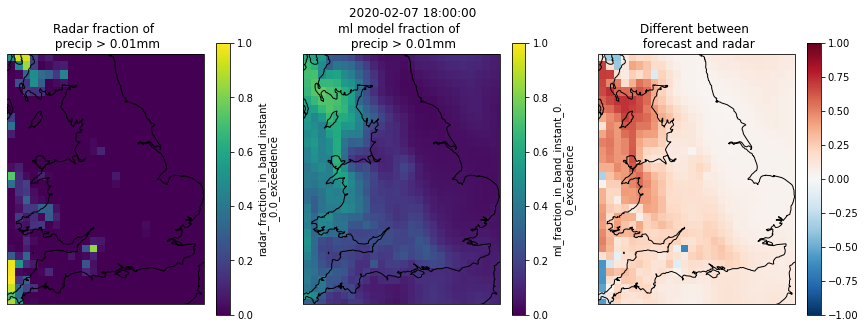

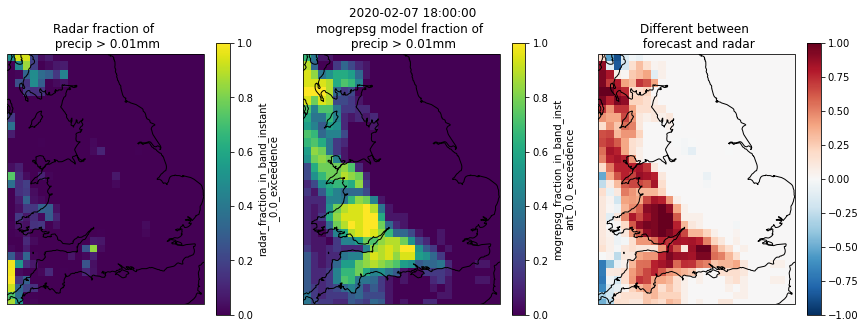

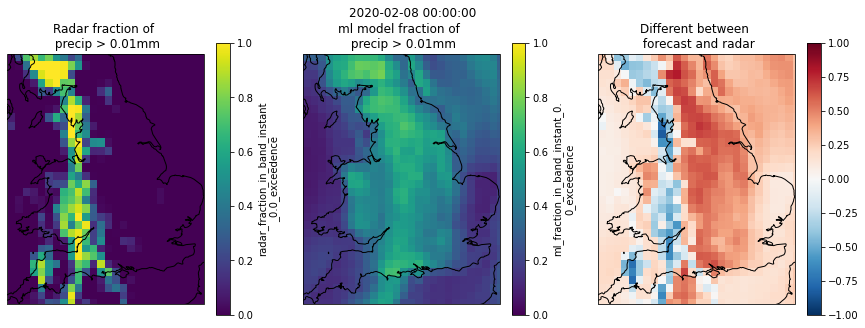

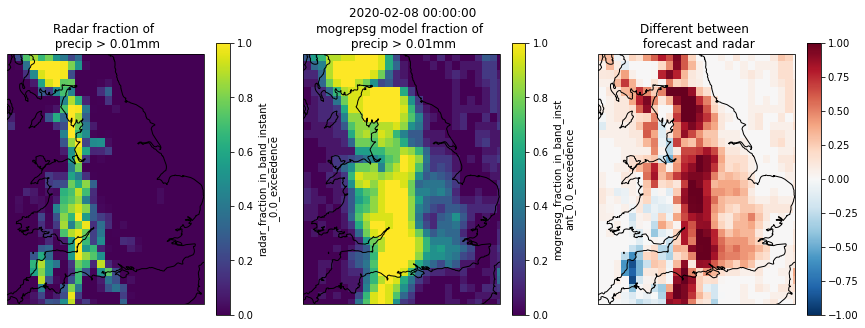

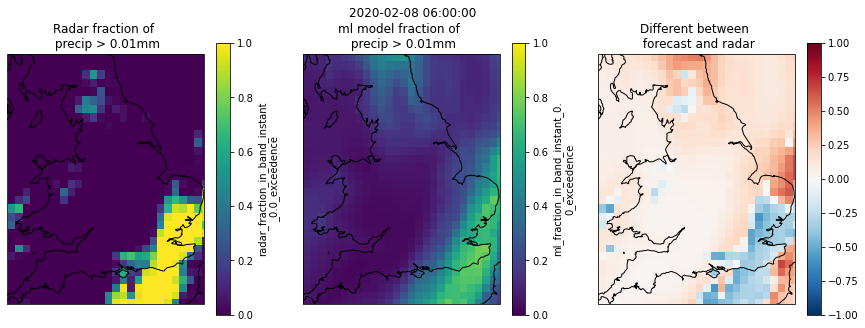

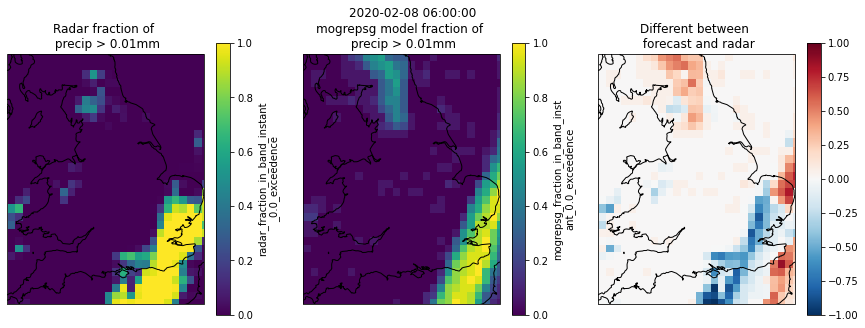

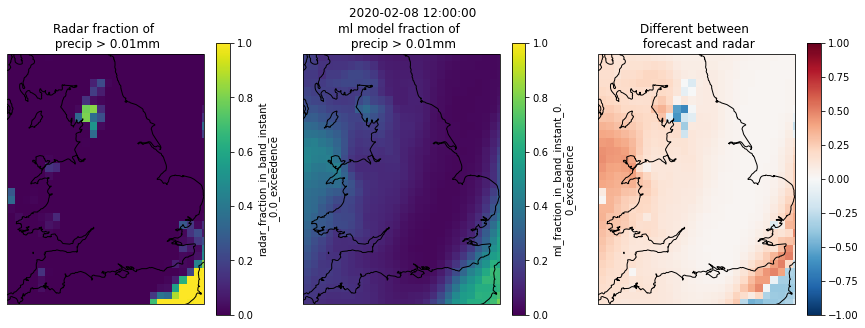

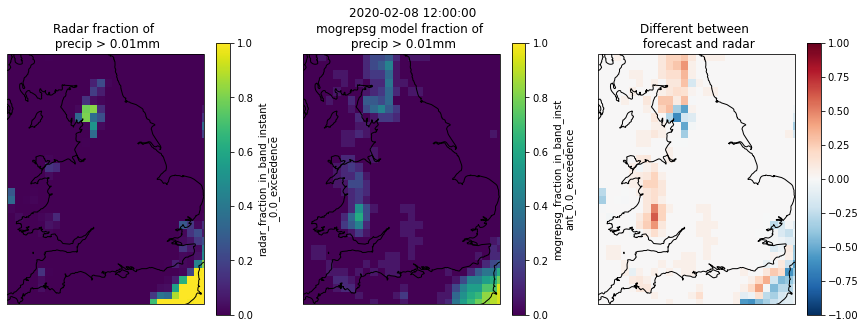

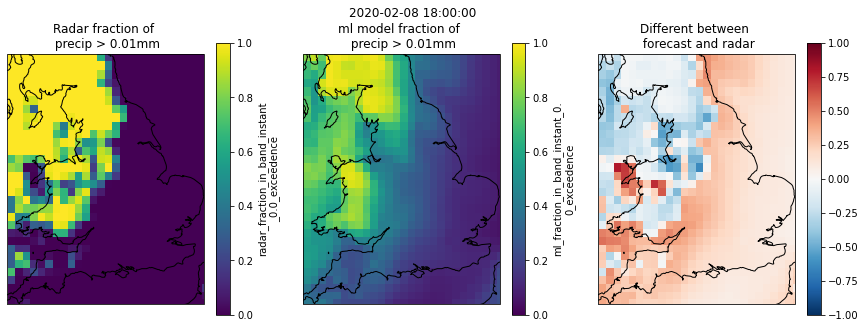

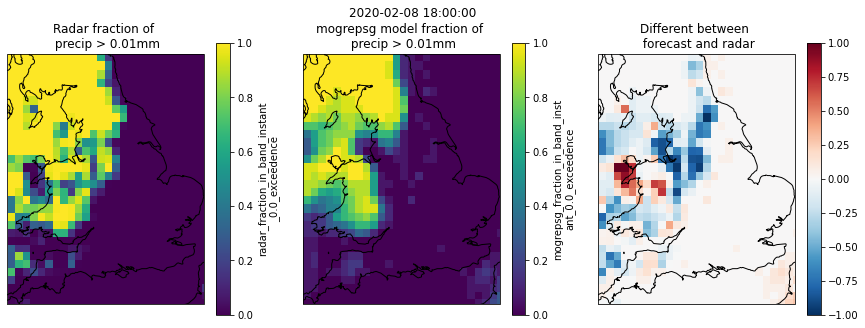

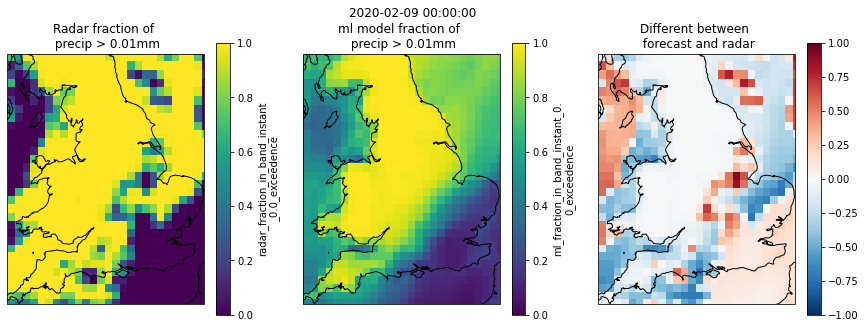

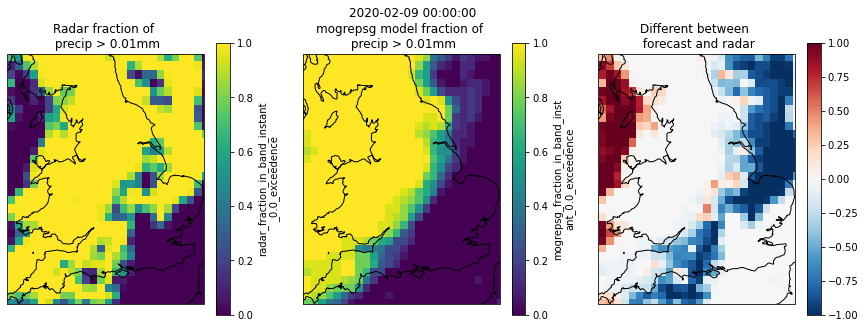

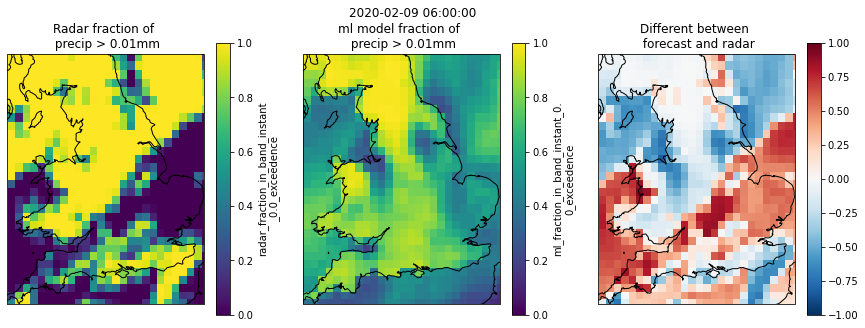

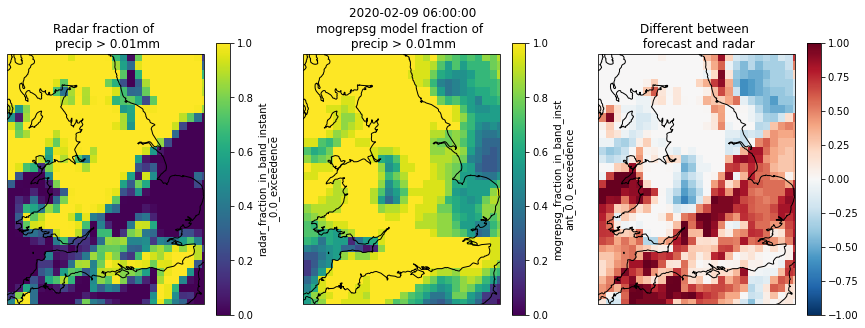

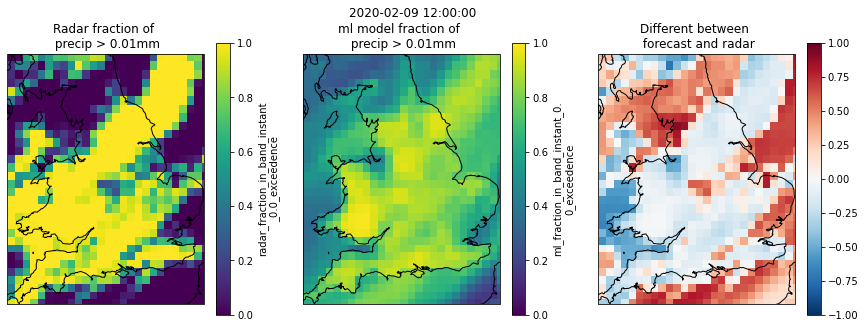

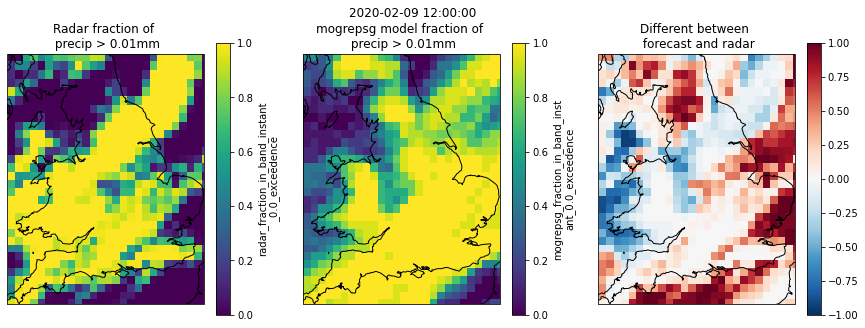

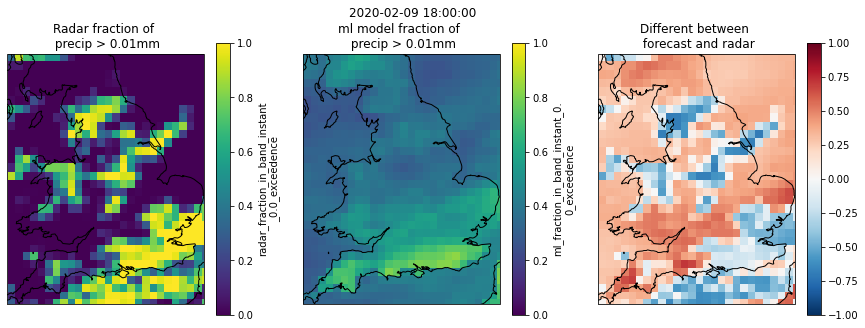

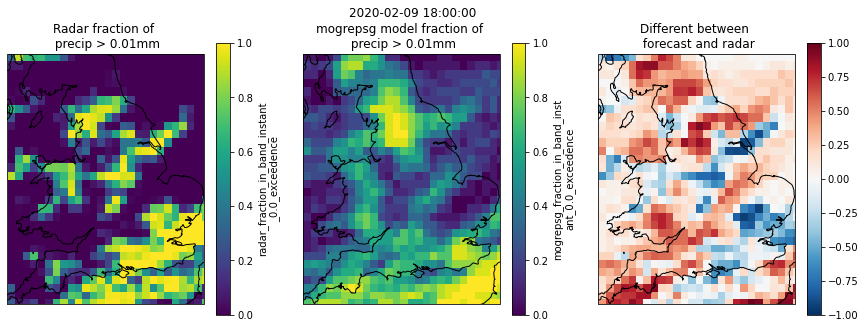

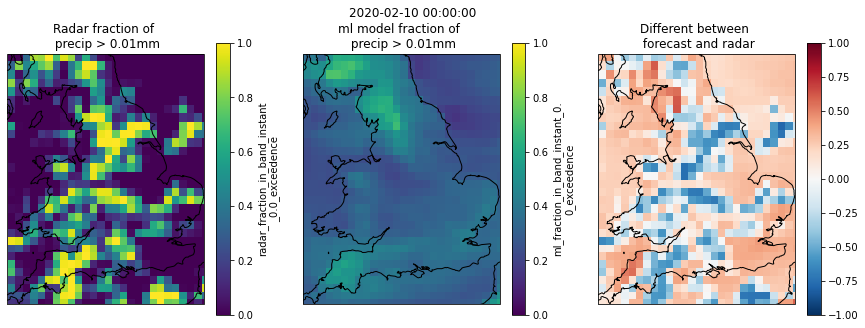

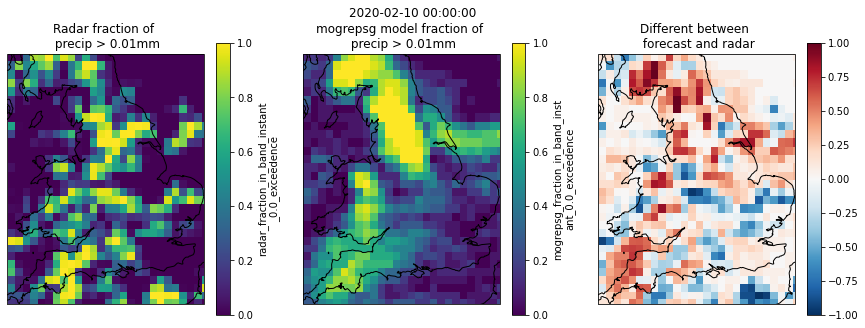

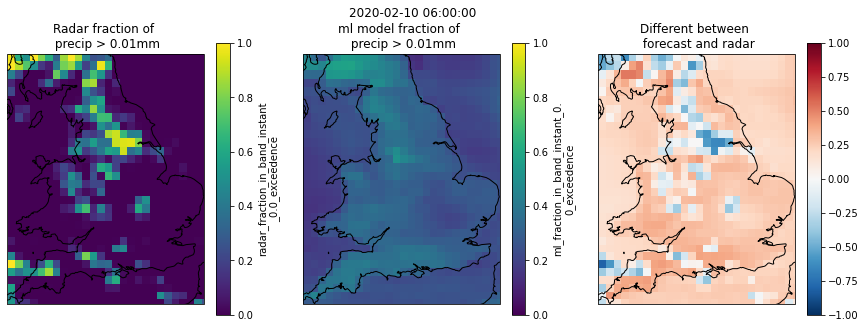

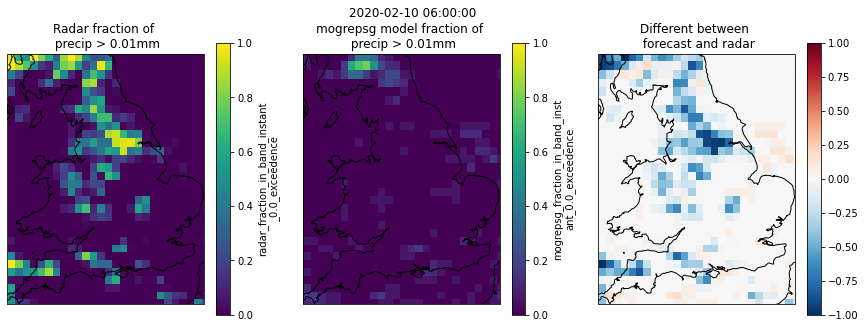

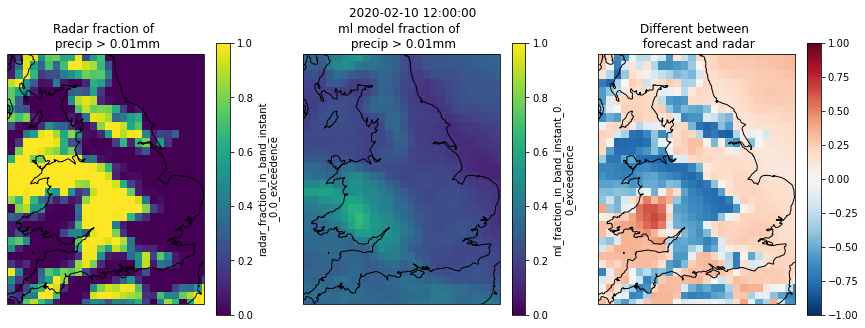

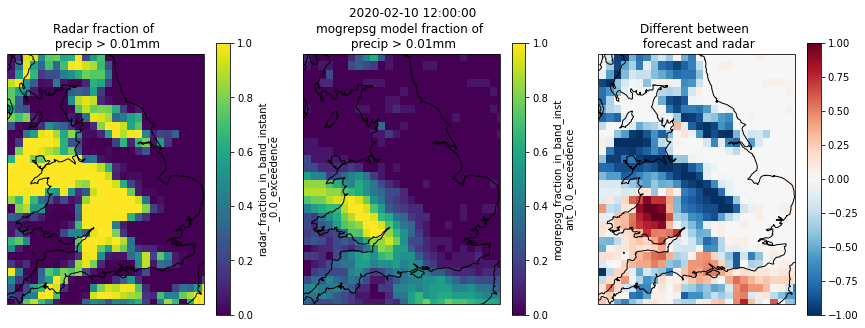

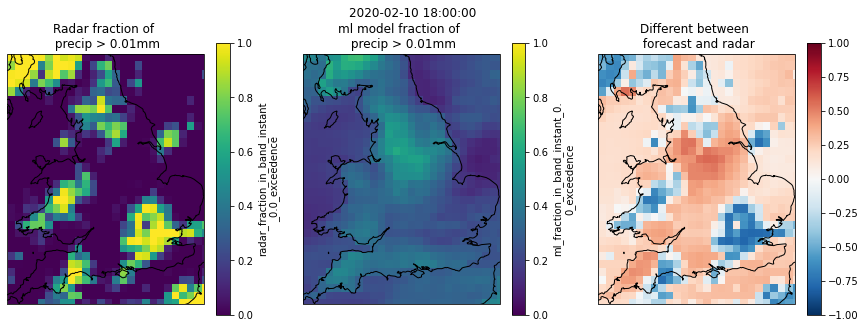

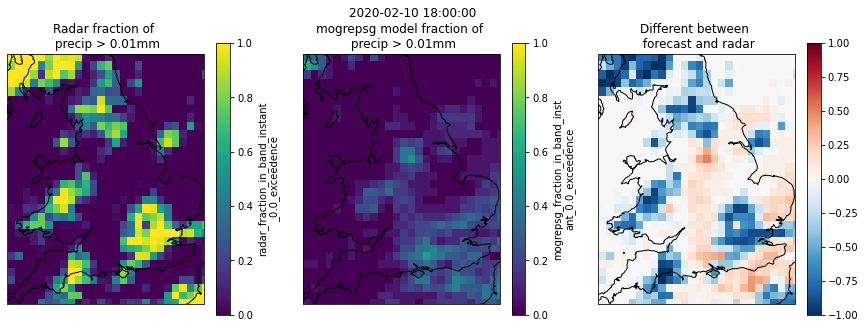

In [17]:
threshold = '0.0'
for time_idx in range(data_xr.time.size):
    prd_pipeline.plot_forecast(data_xr, '0.0', 'ml', bands[threshold][1], time_idx)
    prd_pipeline.plot_forecast(data_xr, '0.0', 'mogrepsg', bands[threshold][1], time_idx)

To understand the ML predictions that make up the average presented in the plot above, postage stamp plots are used to show the different predictions made by the ML model for each ensemble member. 

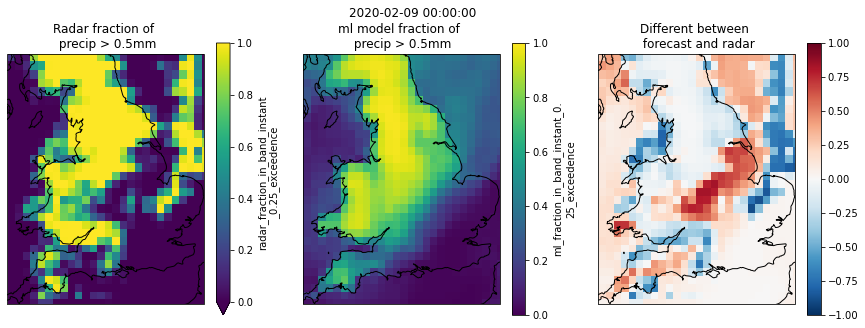

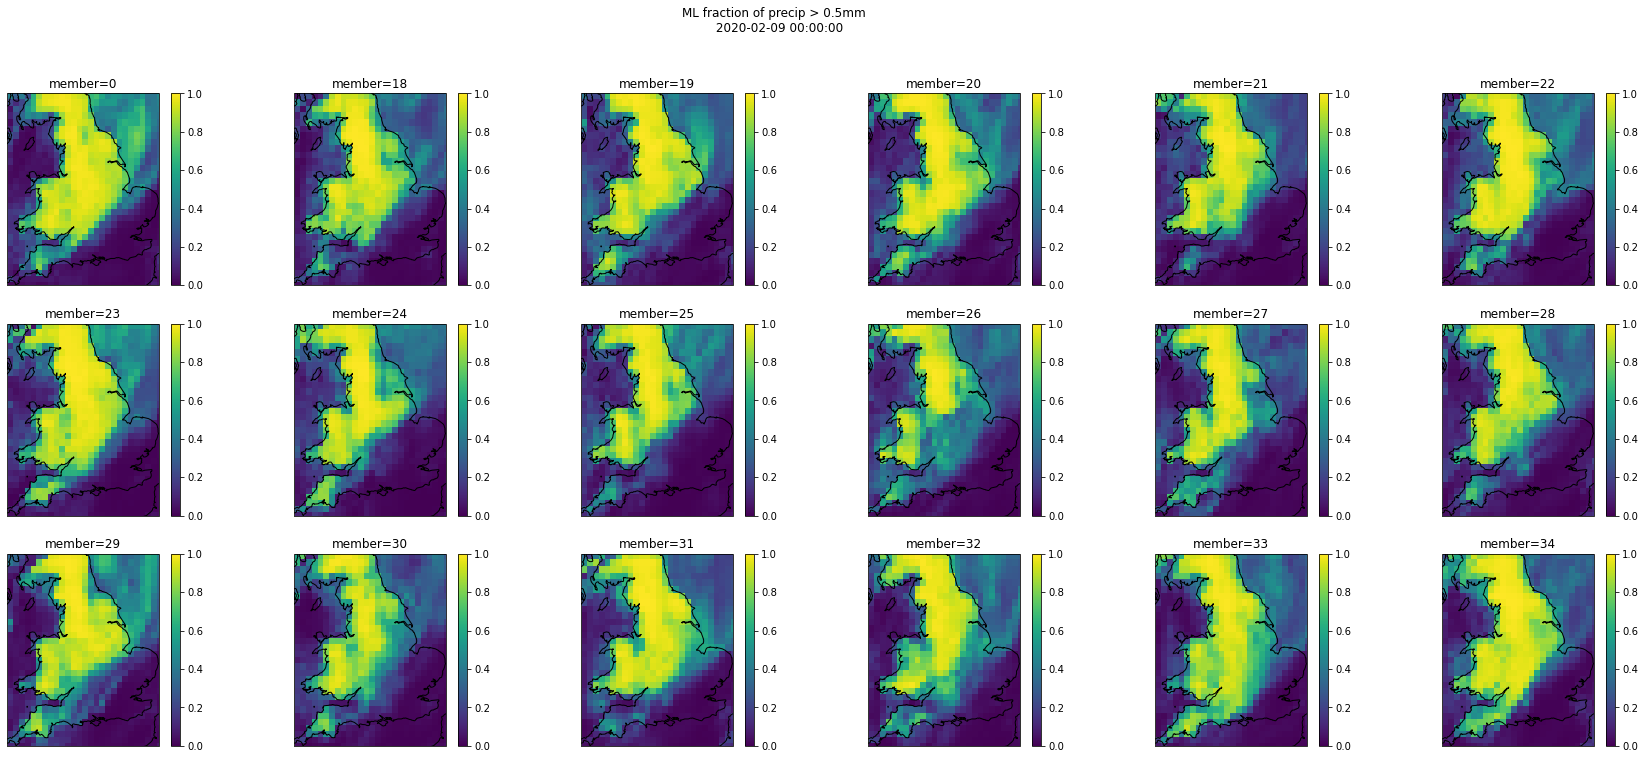

In [22]:
time_idx = 5
threshold = '0.25'
prd_pipeline.plot_forecast(data_xr, threshold, 'ml', bands[threshold][1], time_idx)
prd_pipeline.postage_stamp_plot(test_scenario_evaluation_df, threshold, time_idx, bands)

In [20]:
intensity_bands = [f'{lower_bound}mm-{upper_bound}mm' for lower_bound, upper_bound in bands.values()]

### A line plot is used to show the forecast for an specific location and time. 

The orange shows the NWP probability in each of the precipitation intensity bands, blue the radar fractions in each precip intensity band for this cell and time then each grey line is showing the different precipication fractions predicted by the ML model for the different ensemble members. The green dashed line is the average of all of the grey lines.

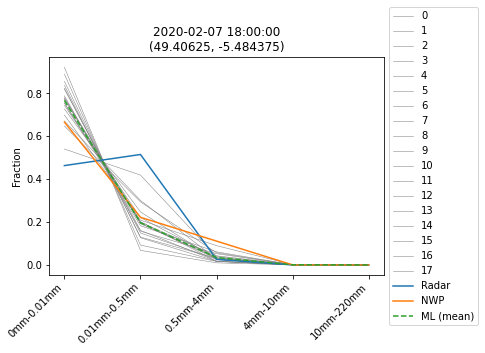

In [21]:
grouped_df = test_scenario_evaluation_df.groupby(['time', 'latitude', 'longitude'])
grouped_df_mean = grouped_df.agg('mean')
group_keys = list(grouped_df.groups.keys())
for i in np.arange(1):
    test_scenario_evaluation_df.iloc[grouped_df.groups[group_keys[i]]][pred_column_names].T.plot(lw=0.5, color='grey', label='_nolegend_')
    
    grouped_df_mean.iloc[i][feature_dict['target']].plot(label='Radar')
    grouped_df_mean.iloc[i][feature_dict['nwp']].plot(label='NWP')
    grouped_df_mean.iloc[i][pred_column_names].plot(label='ML (mean)', ls='--')
    
    plt.ylabel('Fraction')
    plt.xticks(np.arange(5), intensity_bands, rotation=45, ha='right')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(f'{group_keys[i][0]}\n{group_keys[i][1:]}')
    
    plt.show()